<a href="https://colab.research.google.com/github/sethsot/P5_Sentiment-Analysis/blob/main/P5_Sentiment_Analysis_distilbert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
!pip install datasets
!pip install transformers
!pip install -q datasets transformers huggingface_hub accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
#import packages
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import torch

from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric

from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification

from huggingface_hub import notebook_login

import warnings
import re

warnings.filterwarnings('ignore')

In [ ]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
#set random seeds for Pytorch
seed=12
torch.manual_seed(seed)

# further set seeds for GPU operations if using CUDA
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark=False
  torch.cuda.manual_seed_all(seed)

In [ ]:
#Mount the googe drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Navigate to the Colab data folder
%cd drive/MyDrive/Dataset

/content/drive/MyDrive/Dataset


In [ ]:
#load train and test dataset
df=pd.read_csv("/content/drive/MyDrive/Dataset/Train.csv")
test=pd.read_csv("/content/drive/MyDrive/Dataset/Test.csv")

In [ ]:
#preview df

df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [ ]:
#preview test

test.head()

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [ ]:
# Eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]
df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [ ]:
# Eliminate rows containing NaN values
test = test[~test.isna().any(axis=1)]
test.isna().sum()

tweet_id     0
safe_text    0
dtype: int64

In [ ]:
df


,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.000000
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.000000
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.000000
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.000000
...,...,...,...,...
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.000000
9997,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.666667
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.000000
9999,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000


In [ ]:
df['safe_text'][:30]

0     Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1     I'm 100% thinking of devoting my career to pro...
2     #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3     I mean if they immunize my kid with something ...
4     Thanks to <user> Catch me performing at La Nui...
5     <user> a nearly 67 year old study when mental ...
6     Study of more than 95,000 kids finds no link b...
7                      psa: VACCINATE YOUR FUCKING KIDS
8     Coughing extra on the shuttle and everyone thi...
9     AIDS vaccine created at Oregon Health &amp; Sc...
10    <user> @ this point I have 2 text, butw/Bon Jo...
11    My prediction, vaccine exemption in Arizona wi...
12    Getting my vaccines ! #china #nervous #moving ...
13    1$Mug Noche <user> #mmr #mixmasterrod #dcdj #m...
14    Got my Influenza Vaccine! (@ Purdue University...
15    SB121 [Enroll] Meningococcal disease-pupils to...
16    Increasing number of parents skip vaccinations...
17    <user> Thank you for standing with CA pare

In [ ]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove "<user>"
    text = re.sub(r'<user>', '', text)
    # Remove non-alphabetic characters (including punctuation and numbers)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove leading white spaces
    text = re.sub(r'^\s+', '', text)
    return text


In [ ]:
#apply the clean_text function to the 'safe_text' column

df['safe_text'] = df['safe_text'].apply(clean_text)

In [ ]:
df['safe_text'][10:50]

10    this point I have  text butwBon Jovi cover pla...
11    My prediction vaccine exemption in Arizona wil...
12    Getting my vaccines  china nervous moving  Wit...
13    Mug Noche  mmr mixmasterrod dcdj mmr    Mad Ha...
14    Got my Influenza Vaccine  Purdue University St...
15    SB Enroll Meningococcal diseasepupils to be im...
16    Increasing number of parents skip vaccinations...
17    Thank you for standing with CA parents and the...
18    Dude idc if Disney Land has the measles that m...
19    BeefTalk Start your calf vaccinations now url ...
20    I dont care what  says you should probably get...
21    ACR small study shows in  pts with lupus shing...
22    CDC Measles epidemic poses travel risks usatly...
23    Every time I see the to vaccinate or not debat...
24    CDC lied and hid data that black boys have an ...
25                              vaccines causing autism
26    I rarely see arguments about over vaccination ...
27    Im not obsessed w Ebola just following an 

In [ ]:
#remove extra white spaces
def extra_spaces(text):
  #replace all whitespace characters with a single space
  text=re.sub(r'\s+', ' ', text)
  return text

In [ ]:
#apply the clean_text function to the 'safe_text' column

df['safe_text'] = df['safe_text'].apply(extra_spaces)
df['safe_text'].sample(10)

4770                        mmr Where you at pedalpalooza
6269    Come Music Stay For The Booze madhatterdc mmr ...
6192    When we know millions of our nations children ...
1049    Flu vaccine little boy mohawk Whats not to lov...
2996       VaccinesWork to give children everywhere a url
3759    This whole measles thing is ridiculous Vaccina...
8882    Groups want stricter vaccination rules A group...
7195    Parents need to have an open and honest discus...
6896    Not dead virusIts live attenuated Trial expand...
6408    Change in policy likely to lower number of exe...
Name: safe_text, dtype: object

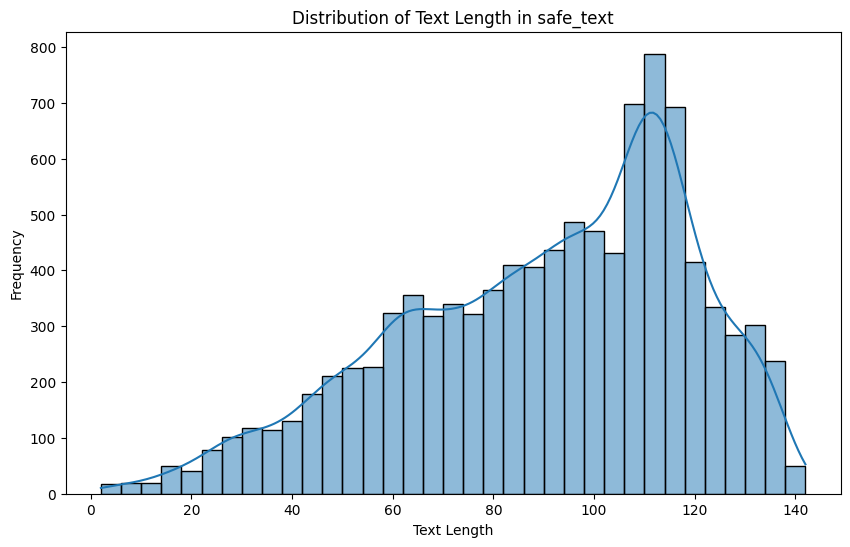

In [ ]:
# Analysis the text length in safe_text
# Calculate the text lengths and store them in a new column 'text_length'
df['text_length'] = df['safe_text'].apply(len)


# Create a histogram of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length in safe_text')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 10000
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tweet_id     9999 non-null   object 
 1   safe_text    9999 non-null   object 
 2   label        9999 non-null   float64
 3   agreement    9999 non-null   float64
 4   text_length  9999 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 468.7+ KB


In [ ]:
df['label'].value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

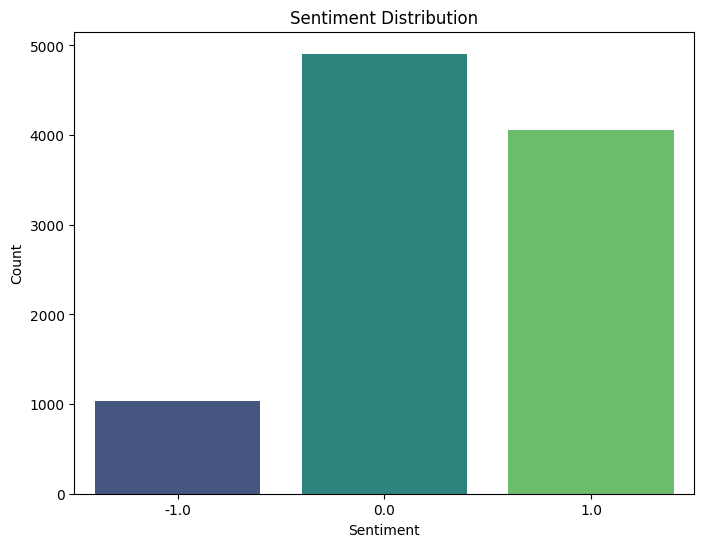

In [ ]:
# Calculate the counts of each sentiment label
sentiment_counts = df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In the above graph, -1.0 ==> negative sentiment, 0.0 ==> neutral sentiment, 1.0==> positive sentiment


In [ ]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 5), eval is (2000, 5)


In [ ]:
dataset = load_dataset('csv',
                        data_files={'train': '/content/drive/MyDrive/Dataset/train_subset.csv',
                        'eval': '/content/drive/MyDrive/Dataset/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1.0: #'Negative'
        num = 0
    elif label == 0.0: #'Neutral'
        num = 1
    elif label == 1.0: #'Positive'
        num = 2

    return {'labels': num}



In [ ]:
tokenizer=AutoTokenizer.from_pretrained(MODEL)

In [ ]:
#def tokenize_data(example):
#  return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
#dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
#remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
#dataset = dataset.map(transform_labels, remove_columns=remove_columns)

In [ ]:
def tokenize_data(data):
  return tokenizer(data['safe_text'], padding='max_length',truncation=True, max_length=256)

In [ ]:
# Tokenize the tweets
dataset=dataset.map(tokenize_data, batched=True)

#Transform labels and limit the columns
remove_columns=['tweet_id', 'label', 'safe_text', 'agreement']
dataset=dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
model=AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./output',
    save_total_limit=2,
    evaluation_strategy="steps",  # Choose "steps" or "epoch" based on your preference.
    eval_steps=500,  # The number of training steps between evaluations.
    load_best_model_at_end=True,
    num_train_epochs=10,  # Set the number of training epochs to 10.
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Define evaluation metrics
metric=load_metric('accuracy')

def compute_metrics(pred):
  logits, labels=pred
  predictions=np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import DataCollatorWithPadding

In [ ]:
train_dataset = dataset['train'].shuffle(seed=12)
eval_dataset = dataset['eval'].shuffle(seed=12)

In [ ]:
data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=256, return_tensors="pt")

In [ ]:
# Set up the training arguments
trainer=Trainer(model,
                  args = training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  compute_metrics=compute_metrics,
)

In [39]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.713000,0.640127,0.750500
1000,0.638300,0.565115,0.779000
1500,0.497400,0.676407,0.774000
2000,0.503000,0.610300,0.783000


Step,Training Loss,Validation Loss,Accuracy
500,0.713000,0.640127,0.750500
1000,0.638300,0.565115,0.779000
1500,0.497400,0.676407,0.774000
2000,0.503000,0.610300,0.783000
2500,0.393300,0.783311,0.781000
3000,0.380900,0.880254,0.785500
3500,0.280600,1.049416,0.780000
4000,0.305100,0.921117,0.798500
4500,0.207200,1.097839,0.788000
5000,0.210700,1.332289,0.793000


TrainOutput(global_step=10000, training_loss=0.2441432876586914, metrics={'train_runtime': 4348.1417, 'train_samples_per_second': 18.396, 'train_steps_per_second': 2.3, 'total_flos': 1.052322114203136e+16, 'train_loss': 0.2441432876586914, 'epoch': 10.0})

In [40]:
#dataset

In [41]:
# Launch the final evaluation
trainer.evaluate()

{'eval_loss': 0.5651150345802307,
 'eval_accuracy': 0.779,
 'eval_runtime': 29.5131,
 'eval_samples_per_second': 67.766,
 'eval_steps_per_second': 8.471,
 'epoch': 10.0}

In [ ]:
notebook_login()

In [1]:
trainer.push_to_hub()

NameError: ignored